In [1]:
import numpy as np
import xarray as xr
import stmat
import geopandas as gpd
import shapely as sp

Initialize raster coordinate information:

In [33]:
minx = 5 
maxx = 10
miny = 50
maxy = 55
dx = 0.5 #Resolution in x
dy = 0.5 #Resolution in y

nx = (maxx - minx)/dx
ny = (maxy - miny)/dy

xras = np.arange(minx, maxx, dx)
yras = np.arange(miny, maxy, dy)

xxras, yyras =np.meshgrid(xras,yras) #Raster meshgrid
print (xxras.shape)

(10, 10)


Create synthetic data 

In [3]:
n_points = 10000
n_time = 1

synthetic h2ph data

In [4]:
stack = np.empty((n_points,0))

for i in range(1):
    slc= np.random.random((100,100))
    stack = np.append(stack, slc[0:100,0:100].reshape(n_points,1), axis=1)

stack = np.array(stack*10, dtype='int')
print(stack.shape)


(10000, 1)


Case 1: synthetic coords (sorted in x and y)

In [5]:
x = np.sort(np.random.random(100)*(maxx - minx) + minx)
y = np.sort(np.random.random(100)*(maxy - miny) + miny)

In [6]:
xx, yy = np.meshgrid(x,y)
xxreshape = xx.reshape(n_points,1)
yyreshape = yy.reshape(n_points,1)
xx

array([[5.00324373, 5.02304993, 5.03510441, ..., 9.89674037, 9.90247335,
        9.95201049],
       [5.00324373, 5.02304993, 5.03510441, ..., 9.89674037, 9.90247335,
        9.95201049],
       [5.00324373, 5.02304993, 5.03510441, ..., 9.89674037, 9.90247335,
        9.95201049],
       ...,
       [5.00324373, 5.02304993, 5.03510441, ..., 9.89674037, 9.90247335,
        9.95201049],
       [5.00324373, 5.02304993, 5.03510441, ..., 9.89674037, 9.90247335,
        9.95201049],
       [5.00324373, 5.02304993, 5.03510441, ..., 9.89674037, 9.90247335,
        9.95201049]])

In [7]:
stack_xx = np.empty((n_points,0))
stack_yy = np.empty((n_points,0))

for i in range(1):
    stack_xx = np.append(stack_xx, xxreshape, axis=1)
    stack_yy = np.append(stack_yy, yyreshape, axis=1)

print(stack_xx)
print(stack_xx.shape)


[[5.00324373]
 [5.02304993]
 [5.03510441]
 ...
 [9.89674037]
 [9.90247335]
 [9.95201049]]
(10000, 1)


In [8]:
data_xr = xr.Dataset(data_vars=dict(h2ph=(["points", "time"], stack), xv=(["points","time"],stack_xx),yv=(["points","time"],stack_yy),),
                     coords=dict(
                        points=np.arange(n_points),
                        time=np.arange(n_time),
                        ))

data_xr

<xarray.Dataset>
Dimensions:  (points: 10000, time: 1)
Coordinates:
  * points   (points) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * time     (time) int64 0
Data variables:
    h2ph     (points, time) int64 8 2 0 1 2 2 5 1 0 6 1 ... 0 2 6 4 2 6 3 2 5 6
    xv       (points, time) float64 5.003 5.023 5.035 ... 9.897 9.902 9.952
    yv       (points, time) float64 50.02 50.02 50.02 ... 54.94 54.94 54.94

In [9]:
import rasterio
from rasterio import features
from rasterio import enums
import affine

In [10]:
df = data_xr.to_dataframe().reset_index()

gdf = gpd.GeoDataFrame(
    df.h2ph, geometry=gpd.points_from_xy(df.xv,df.yv))

gdf.sort_values('h2ph')

,h2ph,geometry
3195,0,POINT (9.85427 51.82315)
3636,0,POINT (6.65147 52.09543)
3647,0,POINT (7.24889 52.09543)
991,0,POINT (9.63646 50.30864)
3655,0,POINT (7.65289 52.09543)
...,...,...
2316,9,POINT (5.62947 51.28787)
4616,9,POINT (5.62947 52.60672)
1298,9,POINT (9.90247 50.47575)
4591,9,POINT (9.63646 52.49332)


In [27]:
grid_cell  = ((shapes) for shapes in zip(gdf.geometry, gdf.index))
raster = rasterio.features.rasterize(shapes=grid_cell, out_shape =[10,10], fill=np.NAN, all_touched= True, default_value=1, transform=affine.Affine.from_gdal(5.0, 0.5, 0.0, 54.9, 0.0, -0.5)) #, merge_alg= MergeAlg.replace
print (raster)

[[9614. 9621. 9632. 9642. 9651. 9663. 9668. 9679. 9686. 9699.]
 [8414. 8421. 8432. 8442. 8451. 8463. 8468. 8479. 8486. 8499.]
 [7114. 7121. 7132. 7142. 7151. 7163. 7168. 7179. 7186. 7199.]
 [6314. 6321. 6332. 6342. 6351. 6363. 6368. 6379. 6386. 6399.]
 [5314. 5321. 5332. 5342. 5351. 5363. 5368. 5379. 5386. 5399.]
 [4214. 4221. 4232. 4242. 4251. 4263. 4268. 4279. 4286. 4299.]
 [3314. 3321. 3332. 3342. 3351. 3363. 3368. 3379. 3386. 3399.]
 [2314. 2321. 2332. 2342. 2351. 2363. 2368. 2379. 2386. 2399.]
 [1714. 1721. 1732. 1742. 1751. 1763. 1768. 1779. 1786. 1799.]
 [1014. 1021. 1032. 1042. 1051. 1063. 1068. 1079. 1086. 1099.]]


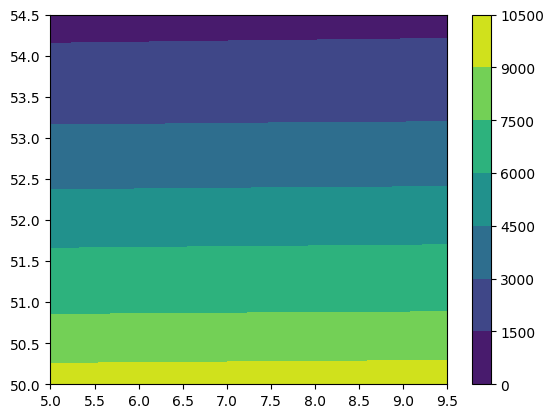

In [34]:
import matplotlib.pyplot as plt

plt.contourf(xxras, yyras, raster)
plt.colorbar()

#plt.scatter Use this!

In [29]:
print(np.unique(raster).shape[0], np.count_nonzero(raster))

100 100


In [30]:
a = np.unique(raster)
a

array([1014., 1021., 1032., 1042., 1051., 1063., 1068., 1079., 1086.,
       1099., 1714., 1721., 1732., 1742., 1751., 1763., 1768., 1779.,
       1786., 1799., 2314., 2321., 2332., 2342., 2351., 2363., 2368.,
       2379., 2386., 2399., 3314., 3321., 3332., 3342., 3351., 3363.,
       3368., 3379., 3386., 3399., 4214., 4221., 4232., 4242., 4251.,
       4263., 4268., 4279., 4286., 4299., 5314., 5321., 5332., 5342.,
       5351., 5363., 5368., 5379., 5386., 5399., 6314., 6321., 6332.,
       6342., 6351., 6363., 6368., 6379., 6386., 6399., 7114., 7121.,
       7132., 7142., 7151., 7163., 7168., 7179., 7186., 7199., 8414.,
       8421., 8432., 8442., 8451., 8463., 8468., 8479., 8486., 8499.,
       9614., 9621., 9632., 9642., 9651., 9663., 9668., 9679., 9686.,
       9699.])

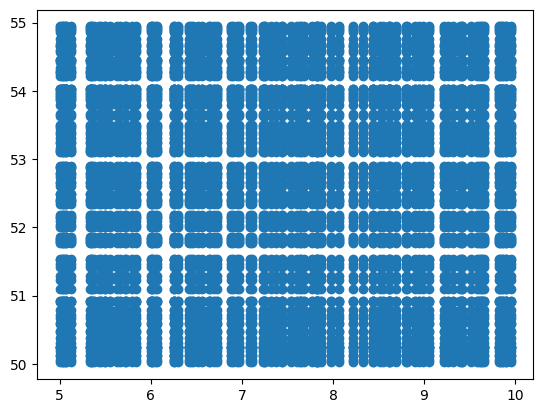

In [31]:
plt.scatter(data_xr.xv, data_xr.yv)

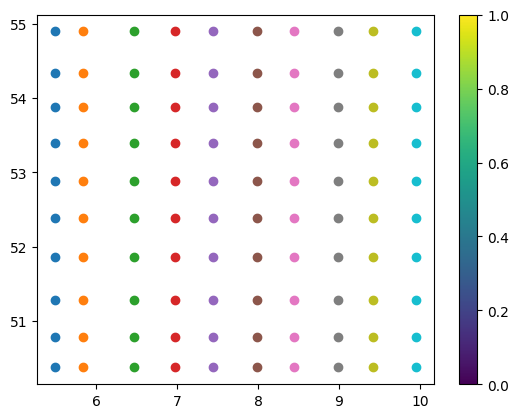

In [35]:
for i in np.unique(raster):
    if i is not np.nan:
        plt.scatter(data_xr.xv[np.int64(i)], data_xr.yv[np.int64(i)])
        